# How to make boundary conditions with slurm arrays

ToDo:
- vertically uniform warming latbc
- initc
- sst

## slurm array example

In [ ]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='proc_4'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%15
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import pandas as pd
import xarray as xr
import numpy as np
import os

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', domain='DOM01', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , domain])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', domain]))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data, domain=domain)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {'clct': 0.5})
    clear_sky = pp.filter_by_threshold(data, {'clct': 0.5}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]                                                                                                                         
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data

def ice_filter(data):
    filter_dict = {'tqi_dia':1e-5}
    unfiltered = data
    filtered = pp.filter_by_threshold(data, filter_dict, below_threshold=True)
    dimname, dimvalues = 'icefilter', [0, filter_dict['tqi_dia']]
    processed_data = xr.concat([unfiltered, filtered], dim=dimname)
    processed_data = processed_data.assign_coords({dimname:(dimname, dimvalues)})
    return processed_data
    
def get_processed(time_index, domain='DOM01'):
    data = get_data(domain=domain)
    data = data.isel(time=time_index)
    data = add_variables(data)
    data = ice_filter(data)
    data = cloud_filter(data)
    data = process_dataset(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

def _main():
    domain = 'DOM01'
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    print(os.environ.get("SLURM_JOB_NAME", 0), f'({task_id}/{task_count})')

    time_array = get_data(domain=domain).time
    time_indices = list(range(len(time_array)))
    time_indices = fh.sublist(time_indices, task_count, task_id)
    print(f'working on {len(time_indices)} time steps ({time_indices[0]} - {time_indices[-1]})')
    
    output_dir = '/scratch/m/m300872/temp/'
    dateformat = "%Y-%m-%d-%H:%M"
    data = get_processed(time_index=time_indices, domain=domain)
    print('start iteration')                                                                                                                                               
    print()
    for t in data.time.values:
        ofile = os.path.join(output_dir, f"pp_{pd.to_datetime(t).strftime(dateformat)}.nc")
        print(ofile, os.path.exists(ofile))
        if not os.path.exists(ofile):
            d = data.sel(time=[t])
            d.to_netcdf(ofile)
        print("\tdone")
    print('all done')
    
if fh.is_running_in_notebook():
    print('In notebook. Not executed.')
elif __name__ == "__main__":
    _main()        

## moist adiabatic bc creation script

In [37]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='mk_latbc'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%15
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import dask # avoid dask warnings in the output
dask.config.set(**{'array.slicing.split_large_chunks': True})
import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
# import pandas as pd
import xarray as xr
# import numpy as np
import os
import calculations as cc
import importlib; importlib.reload(cc)
    
def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = cc.apply_warming_rho_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

def try_remove(path):
    try:os.remove(path)
    except: pass

def _main():
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    print(os.environ.get("SLURM_JOB_NAME", 0), f'({task_id}/{task_count})')

    latbc_varnames = dict()
    latbc_varnames["pressure"] = "pres"
    latbc_varnames["temperature"] = "temp"
    varnames = cc.get_varnames(latbc_varnames)
    
    division = (task_count, task_id)
    IN_DIRECTORY = '/work/bm1183/m300872/unchanged'
    IN_DIRECTORY = '/work/mh1126/m300872/unchanged'
    OUT_DIRECTORY = '/work/bm1183/m300872/moist_adiabatic/'
    temperatures = (304,300)
    
    print('IN_DIRECTORY', IN_DIRECTORY)
    print('OUT_DIRECTORY', OUT_DIRECTORY)
    
    latbc_files = [f for f in fh.list_files(os.path.join(IN_DIRECTORY, 'latbc')) if not 'grid' in f]
    if division: latbc_files = fh.sublist(latbc_files, division[0], division[1])
    print(f'working on {len(latbc_files)} of {len(fh.list_files(os.path.join(IN_DIRECTORY, 'latbc')))} files')
    
    for f in latbc_files:
        dirpath = os.path.dirname(f.replace(IN_DIRECTORY, OUT_DIRECTORY))
        os.makedirs(dirpath, exist_ok=True)
    print()
    
    args_list = list()
    for f in latbc_files:
        ifile = f
        ofile = f.replace(IN_DIRECTORY, OUT_DIRECTORY)
        print(ifile)
        print(ofile, 'exists' if os.path.exists(ofile) else 'missing')
        if not os.path.exists(ofile):
            warm_atmospheric_profile(ifile, ofile, varnames)
        print("\tdone")
    print('all done')

def _test():
    """ should be the same as main, only works on a few preset files. """
    latbc_varnames = dict()
    latbc_varnames["pressure"] = "pres"
    latbc_varnames["temperature"] = "temp"
    varnames = cc.get_varnames(latbc_varnames)
    
    division = (400,0)
    IN_DIRECTORY = '/work/bm1183/m300872/unchanged'
    IN_DIRECTORY = '/work/mh1126/m300872/unchanged'
    OUT_DIRECTORY = '/work/bm1183/m300872/moist_adiabatic/'
    temperatures = (304,300)
    
    print('IN_DIRECTORY', IN_DIRECTORY)
    print('OUT_DIRECTORY', OUT_DIRECTORY)
    
    latbc_files = [f for f in fh.list_files(os.path.join(IN_DIRECTORY, 'latbc')) if not 'grid' in f]
    if division: latbc_files = fh.sublist(latbc_files, division[0], division[1])
    print(f'working on {len(latbc_files)} of {len(fh.list_files(os.path.join(IN_DIRECTORY, "latbc")))} files')

    for f in latbc_files:
        ifile = f
        ofile = f.replace(IN_DIRECTORY, OUT_DIRECTORY)
        print(ifile)
        os.remove(ofile)
        print(ofile, 'exists' if os.path.exists(ofile) else 'missing')
        if not os.path.exists(ofile):
            warm_atmospheric_profile(ifile, ofile, varnames)
        print("\tdone")
    print('all done')
    
if fh.is_running_in_notebook():
    print('----------------------------------\n-- In notebook, executing test. --\n----------------------------------\n')
    _test()
    
elif __name__ == "__main__":
    _main()   

----------------------------------
-- In notebook, executing test. --
----------------------------------

IN_DIRECTORY /work/mh1126/m300872/unchanged
OUT_DIRECTORY /work/bm1183/m300872/moist_adiabatic/
working on 3 of 1024 files
/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
/work/bm1183/m300872/moist_adiabatic//latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc missing
	done
/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc
/work/bm1183/m300872/moist_adiabatic//latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc missing
	done
/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc
/work/bm1183/m300872/moist_adiabatic//latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc missing
	done
all done


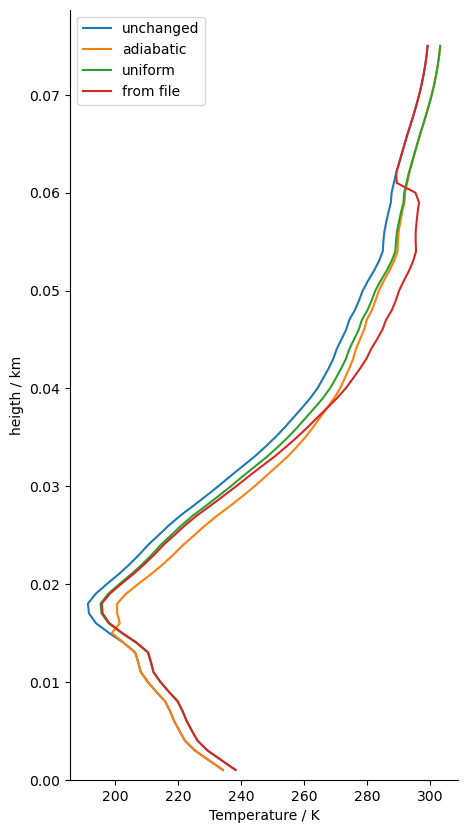

In [36]:
import calculations as cc
import importlib; importlib.reload(cc)

import matplotlib.pyplot as plt
import plot_utils as pu

dataset = xr.open_dataset('/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')
dataset = dataset.isel({'time':0}).median(dim='ncells', keep_attrs=True)

var = 'temp'
fig, ax = plt.subplots(figsize=(5,10))
ax = pu.ax_profile(ax, dataset[var], label='unchanged')
ax = pu.ax_profile(ax, cc.apply_warming_rho_fixed(dataset.copy())[var], label='adiabatic')
ax = pu.ax_profile(ax, cc.apply_uniform_warming_rho_fixed(dataset.copy())[var], label='uniform')
ax = pu.ax_profile(ax, xr.open_dataset('/work/bm1183/m300872/moist_adiabatic//latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc').isel({'time':0}).median(dim='ncells', keep_attrs=True)[var], label='from file')
ax.legend()
fig.show()

## initc

In [1]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='proc_4'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import calculations as cc
import pandas as pd
import xarray as xr
import numpy as np
import os

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def try_remove(path):
    try:os.remove(path)
    except: pass
        
def warm_atmospheric_profile(ifile, ofile, func=None, varnames=None):
    d = xr.open_dataset(ifile)
    d = func(d, varnames=varnames)
    d = cc.add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)
    return None
    
def _main():
    in_directory     = '/work/mh1126/m300872/unchanged/'
    out_directory    = '/work/mh1126/m300872/test/'
    warming_function = cc.apply_warming_rho_fixed
    
    initc_files = [os.path.join('initc',f) for f in fh.list_files(os.path.join(in_directory, 'initc'), full_path=False)]
    fh.create_directory_structure(initc_files, out_directory)
    
    
    for f in initc_files: print(f)
    print('')

    initcon_varnames = dict()
    initcon_varnames["pressure"] = "p"
    initcon_varnames["temperature"] = "t"
    varnames = cc.get_varnames(initcon_varnames)
    
    ifile = os.path.join(in_directory, initc_files[0])
    ofile = os.path.join(out_directory, initc_files[0])

    try_remove(ofile)
    warm_atmospheric_profile(ifile, ofile, warming_function, varnames)
    print('done')

def _test():
    in_directory     = '/work/mh1126/m300872/unchanged/'
    out_directory    = '/work/mh1126/m300872/test/'
    warming_function = cc.apply_warming_rho_fixed
    
    initc_files = [os.path.join('initc',f) for f in fh.list_files(os.path.join(in_directory, 'initc'), full_path=False)]
    fh.create_directory_structure(initc_files, out_directory)
    
    
    for f in initc_files: print(f)
    print('')

    initcon_varnames = dict()
    initcon_varnames["pressure"] = "p"
    initcon_varnames["temperature"] = "t"
    varnames = cc.get_varnames(initcon_varnames)
    
    ifile = os.path.join(in_directory, initc_files[0])
    ofile = os.path.join(out_directory, initc_files[0])

    try_remove(ofile)
    warm_atmospheric_profile(ifile, ofile, warming_function, varnames)
    print('done')
    
if fh.is_running_in_notebook():
    print('In notebook. executing test.')
    _test()
elif __name__ == "__main__":
    _main()  

In notebook. executing test.
initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc

done


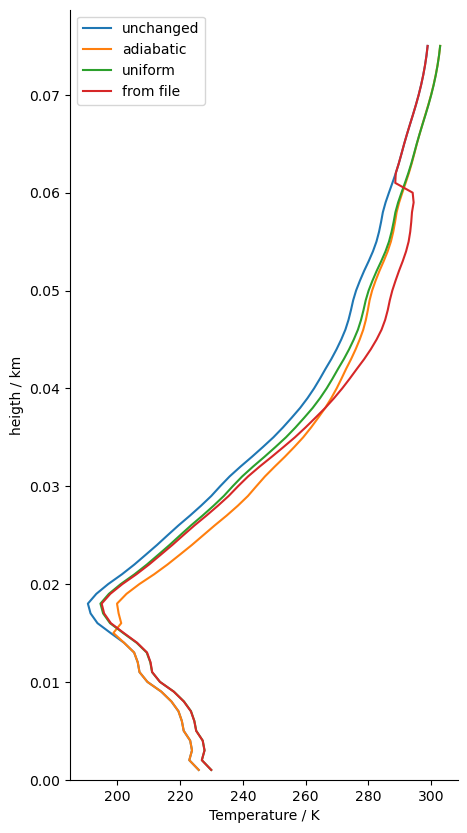

In [4]:
import calculations as cc
import importlib; importlib.reload(cc)

import matplotlib.pyplot as plt
import plot_utils as pu

dataset = xr.open_dataset('/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc')
dataset = dataset.isel({'time':0}).median(dim='ncells', keep_attrs=True)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = cc.get_varnames(initcon_varnames)
    
var = 't'
fig, ax = plt.subplots(figsize=(5,10))
ax = pu.ax_profile(ax, dataset[var], label='unchanged')
ax = pu.ax_profile(ax, cc.apply_warming_rho_fixed(dataset.copy(), varnames=varnames)[var], label='adiabatic')
ax = pu.ax_profile(ax, cc.apply_uniform_warming_rho_fixed(dataset.copy(), varnames=varnames)[var], label='uniform')
ax = pu.ax_profile(ax, xr.open_dataset('/work/mh1126/m300872/test/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc').isel({'time':0}).median(dim='ncells', keep_attrs=True)[var], label='from file')
ax.legend()
fig.show()

## sst

In [1]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='sst'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%3
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh
import postprocessing as pp
import calculations as cc
import pandas as pd
import xarray as xr
import netCDF4
import numpy as np

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)
    
def try_remove(path):
    try:os.remove(path)
    except: pass

def _main():
    task_count = int(os.environ.get("SLURM_ARRAY_TASK_COUNT", 0))
    task_id    = int(os.environ.get("SLURM_ARRAY_TASK_ID", 0))
    print(os.environ.get("SLURM_JOB_NAME", 0), f'({task_id}/{task_count})')

    in_directory  = '/work/mh1126/m300872/unchanged/'
    out_directory = '/scratch/m/m300872/bc_test'
    delta = 4.0
    
    sstsic_files = fh.list_files(os.path.join(in_directory, 'sst_sic'), ['sst_sic_DOM0'], full_path=False)
    sstsic_files = [os.path.join('sst_sic',f) for f in sstsic_files if f.endswith('.nc')]
    f = sstsic_files[task_id]
    ifile = os.path.join(in_directory,f)
    ofile = os.path.join(out_directory,f)
    print('<<', ifile)
    print('>>', ofile)
    
    xr.open_dataset(ifile, chunks={}).assign(SST=lambda dx: dx.SST + delta).to_netcdf(ofile, mode="w")
    print('done')
    
if fh.is_running_in_notebook():
    print('In notebook. Not executed.')
elif __name__ == "__main__":
    _main()

In notebook. Not executed.


In [21]:
xr.open_dataset('/scratch/m/m300872/bc_test/sst_sic/data/sst_sic_DOM01.nc')

<xarray.Dataset> Size: 52GB
Dimensions:    (time: 1440, cell: 4528560, nv: 3)
Coordinates:
  * time       (time) datetime64[ns] 12kB 2020-01-01 ... 2020-02-29T23:00:00
    clon       (cell) float64 36MB ...
    clat       (cell) float64 36MB ...
Dimensions without coordinates: cell, nv
Data variables:
    clon_bnds  (cell, nv) float64 109MB ...
    clat_bnds  (cell, nv) float64 109MB ...
    SST        (time, cell) float32 26GB ...
    SIC        (time, cell) float32 26GB ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    history:              Tue Apr 13 10:30:47 2021: cdo -f nc4 remapbil,../gr...
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    Conventions:          CF-1.6
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...